# Sprint12　畳込みニューラルネットワーク

# ライブラリimport

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# データ準備

In [2]:
# データ読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# onehotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

# 訓練データと評価データに
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(60000, 28, 28)
(12000, 28, 28)
(60000,)
(12000, 10)


# 学習に使用するその他クラスの定義

これまでのsprintで定義してきたものを流用します。

In [3]:
class FC:
    """
    Fully connected layers from number of nodes n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in subsequent layers
    initializer : Instances of initialization methods
    optimizer : Instances of optimization methods
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
        
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        # Initialize.
        # Use the initializer method to initialize self.W and self.B
        self.W = self.initializer.W(self.n_nodes1,self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        
    def forward(self, X):
        """
        Forward
        Parameters
        ----------
        X : ndarray of the following form, shape (batch_size, n_nodes1)
            Input
        Returns
        ----------
        A : ndarray of the following form, shape (batch_size, n_nodes2)
            Output
        """
        self.X = X
        self.A = np.dot(self.X,self.W) + self.B
        
        return self.activation.forward(self.A)
    
    def backward(self, dZ):
        """
        Backward
        Parameters
        ----------
        dA : ndarray of the following form, shape (batch_size, n_nodes2)
            The gradient flowed in from behind.
        Returns
        ----------
        dZ : ndarray of the following form, shape (batch_size, n_nodes1)
            forward slope
        """
        dA = self.activation.backward(dZ)
        self.dB = np.mean(dA,axis=0)
        self.dW = np.dot(self.X.T,dA)/len(self.X)
        dZ = np.dot(dA,self.W.T)
        
        # Update
        self = self.optimizer.update(self)
        
        return dZ
    
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        Initializing weights
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        W : weight
        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        B : bias
        """
        return np.zeros(n_nodes2)
    
class HeInitializer():
    """
    Initialization of weights by He
    """
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        Initializing weights
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        W : weight
        """
        return np.random.randn(n_nodes1, n_nodes2)*np.sqrt(2/n_nodes1)
    
    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        B : bias
        """
        return np.zeros(n_nodes2)
    
class SGD:
    """
    stochastic gradient descent method
    Parameters
    ----------
    lr : learning rate
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, layer):
        """
        Updating the weights and biases of a layer
        Parameters
        ----------
        layer : An instance of the layer before the update
        """
        layer.W -= self.lr*layer.dW
        layer.B -= self.lr*layer.dB
        
        return layer
    
class AdaGrad:
    """
    stochastic gradient descent method
    Parameters
    ----------
    lr : learning rate
    """
    def __init__(self, lr):
        self.lr = lr
        self.hW = 0
        self.hB = 0
        
    def update(self, layer):
        """
        Updating the weights and biases of a layer
        Parameters
        ----------
        layer : An instance of the layer before the update
        """
        self.hW += layer.dW*layer.dW
        self.hB = layer.dB*layer.dB
    
        layer.W -= self.lr*layer.dW/(np.sqrt(self.hW) +1e-7)
        layer.B -= self.lr*layer.dB/(np.sqrt(self.hB) +1e-7)
        
        return layer
    
class ReLU():
    """
    Activation function : ReLU function
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        self.A = A
        return np.maximum(self.A,0)
    
    def backward(self,dZ):
        
        return np.where(self.A>0,dZ,0)
    
class Softmax():
    """
    Activation Function : Softmax Function
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        
        return np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)),axis=1,keepdims=True)
    
    def backward(self,dZ):
        return dZ
    
# Mini-batch processing class
class GetMiniBatch:
    """
    Iterator to get the mini-batch

    Parameters
    ----------
    X : ndarray of the following form, shape (n_samples, n_features)
      Training data
    y : ndarray of the following form, shape (n_samples, 1)
      correct value
    batch_size : int
      Batch size
    seed : int
      Seeding random numbers in NumPy
    """
    def __init__(self, X, y, batch_size = 20, seed=None):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1] 
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

# 畳み込み層の重みとバイアスの初期化クラス

In [4]:
class SimpleInitializerConv2d:
    """重みとバイアスの初期化（畳込み用）"""
    def __init__(self, sigma=0.01):
        """コンストラクタ
        Parameters
        --------------
        sigma : ガウス分布の標準偏差
        """
        self.sigma = sigma
        
    def W(self, F, C, FH, FW):
        """重み初期化
        Parameters
        ----------
        F : フィルタ数
        C : チャンネル数
        FH : フィルターの高さ
        FW : フィルターの横幅
        """
        return self.sigma * np.random.randn(F,C,FH,FW)
    
    def B(self, F):
        """バイアス初期化
        Parameters
        ----------
        F : フィルタ数
        """
        return np.zeros(F)

# 問題1　2次元畳み込み層の作成

https://qiita.com/eijian/items/c947fb6b5e7a49858fb4#2-3-%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E5%B1%A4

$$a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}$$

In [5]:
class SimpleConv2d():
    """2次元畳み込みレイヤ"""
    def __init__(self, F, C, FH, FW, P, S,
                 initializer=None,optimizer=None,activation=None):
        """コンストラクタ
        Parameters
        -------------
        F : フィルタ数
        C : チャンネル数
        FH : フィルターの高さ
        FW : フィルターの横幅
        P : パディング数
        S : ストライド数
        initializer : 初期化
        optimizer : 最適化手法
        activation : 活性化関数
        """
        self.P = P
        self.S = S
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        # 重みとバイアスの初期化
        self.W = self.initializer.W(F,C,FH,FW)
        self.B = self.initializer.B(F)
        
    def output_shape2d(self,H,W,PH,PW,FH,FW,SH,SW):
        """出力サイズ計算
        H : 入力配列の高さ
        W : 入力配列の横幅
        FH : フィルターの高さ
        FW : フィルターの横幅
        PH : パディング数（縦）
        PW : パディング数（横）
        SH : ストライド数（縦）
        SW : ストライド数（横）
        """
        # 高さ計算
        OH = (H +2*PH -FH)/SH +1
        # 横幅計算
        OW = (W +2*PW -FW)/SW +1
        
        return int(OH),int(OW)
    
    def forward(self, X,debug=False):
        """順伝播
        Parameters
        ------------
        X : 入力配列
        """
        # Xをメンバ変数化
        self.X = X
        # 入力配列と重みの大きさ取得
        N,C,H,W = self.X.shape
        F,C,FH,FW = self.W.shape
        # 出力サイズ計算
        OH,OW = self.output_shape2d(H,W,self.P,self.P,FH,FW,self.S,self.S)
        # 各種サイズをメンバ変数化
        self.params = N,C,H,W,F,FH,FW,OH,OW
        # 返り値の初期化（これを上書きしていく）
        A = np.zeros([N,F,OH,OW])
        # 計算のためパディング処理
        self.X_pad = np.pad(self.X,((0,0),(0,0),(self.P,self.P),(self.P,self.P)))

        # バッチ数でループ
        for n in range(N):
            # フィルター数でループ
            for ch in range(F):
                # 高さでループ（ストライドを考慮）
                for row in range(0,H,self.S):
                    # 横幅でループ（ストライドを考慮）
                    for col in range(0,W,self.S):
                        if self.P == 0 and (W-2 <= col or H-2<=row):
                            continue
                        # 各要素計算
                        A[n,ch,row,col] = \
                        np.sum(self.X_pad[n,:,row:row+FH,col:col+FW]
                               *self.W[ch,:,:,:]) +self.B[ch]
        # 活性化関数に通して返す
        if debug==True:
            return A
        else:
            return  self.activation.forward(A)
    
    def backward(self, dZ,debug=False):
        """逆伝播
        Parameters
        -----------
        dZ : 逆伝播してきた値
        """
        # 活性化関数の逆伝播処理
        if debug==True:
            dA = dZ
        else:
            dA = self.activation.backward(dZ)
        # 順伝播の際にメンバ変数化しておいた各種サイズを取得
        N,C,H,W,F,FH,FW,OH,OW = self.params
        # 返り値と重みとバイアスの初期化（これを上書きしていく）
        dZ = np.zeros(self.X_pad.shape) # X_padのサイズで初期化していることに注意
        self.dW = np.zeros(self.W.shape)
        self.dB = np.zeros(self.B.shape)
        
        # dZ（逆伝播）
        # バッチ数でループ
        for n in range(N):
            # フィルター数でループ
            for ch in range(F):
                # 高さでループ（ストライドを考慮）
                for row in range(0,H,self.S):
                    # 横幅でループ（ストライドを考慮）
                    for col in range(0,W,self.S):
                        if self.P == 0 and (W-2 <= col or H-2<=row):
                            continue
                        # 各要素計算
                        dZ[n,:,row:row+FH,col:col+FW] += dA[n,ch,row,col]*self.W[ch,:,:,:]
        
        # X_padのサイズになっているので、不要な部分を削除
        if self.P == 0:
            dZ = np.delete(dZ,[0,H-1],axis=2)
            dZ = np.delete(dZ,[0,W-1],axis=3)
        else:
            dl_rows = range(self.P),range(H+self.P,H+2*self.P,1)
            dl_cols = range(self.P),range(W+self.P,W+2*self.P,1)
            dZ = np.delete(dZ,dl_rows,axis=2)
            dZ = np.delete(dZ,dl_cols,axis=3)
 
        # dW（重み）
        # バッチ数でループ
        for n in range(N):
            # フィルター数でループ
            for ch in range(F):
                # 高さでループ
                for row in range(OH):
                    # 横幅でループ
                    for col in range(OW):
                        # 各要素計算
                        self.dW[ch,:,:,:] += dA[n,ch,row,col]*self.X_pad[n,:,row:row+FH,col:col+FW]
        
        # dB（バイアス）
        # フィルター数でループ
        for ch in range(F):
            self.dB[ch] = np.sum(dA[:,ch,:,:])
        
        # 重み更新
        self = self.optimizer.update(self)
        
        return dZ

# 問題2　小さな配列での2次元畳み込み層の実験

In [6]:
# データの定義
x = np.array([[[[ 1,  2,  3,  4],[ 5,  6,  7,  8],[ 9, 10, 11, 12],[13, 14, 15, 16]]]])
w = np.array([[[[ 0.,  0.,  0.],[ 0.,  1.,  0.],[ 0., -1.,  0.]]],[[[ 0.,  0.,  0.],[ 0., -1.,  1.],[ 0.,  0.,  0.]]]])
da = np.array([[[[ -4,  -4], [ 10,  11]],[[  1,  -7],[  1, -11]]]])

# インスタンス定義と重み上書き
simple_conv_2d = SimpleConv2d(F=2, C=1, FH=3, FW=3, P=0, S=1,initializer=SimpleInitializerConv2d(),optimizer=SGD(),activation=ReLU())
simple_conv_2d.W = w

# 順伝播
A = simple_conv_2d.forward(x,True)
print(A)

# 逆伝播
dZ = simple_conv_2d.backward(da,True)
print(dZ)

[[[[-4. -4.]
   [-4. -4.]]

  [[ 1.  1.]
   [ 1.  1.]]]]
[[[[-5.  4.]
   [13. 27.]]]]


### mnistを使ったテスト

In [7]:
# ストライド/パディング/バッチ数の定義
S = 1
P = 1
N = 5 

# 入力配列と重みのサイズ定義
N,C,H,W = (5,1,28,28)
F,C,FH,FW = (4,1,3,3)

# X（入力配列生成）
X_sample = X_train[0:N].reshape(N,C,H,W)

# インスタンス生成
simple_conv_2d = SimpleConv2d(F=F, C=C, FH=FH, FW=FW, P=P, S=S,initializer=SimpleInitializerConv2d(),optimizer=SGD(),activation=ReLU())

# 順伝播
A = simple_conv_2d.forward(X_sample)
print(A.shape)

# 逆伝播
dA = np.ones(A.shape)
dZ = simple_conv_2d.backward(X_sample)
print(dZ.shape)

(5, 4, 28, 28)
(5, 1, 28, 28)


# 問題3　2次元畳み込み後の出力サイズ

問題2のクラス内で定義済み

In [8]:
simple_conv_2d.output_shape2d(H=6,W=6,PH=0,PW=0,FH=3,FW=3,SH=1,SW=1)

(4, 4)

# 問題4　最大プーリング層の作成

https://qiita.com/eijian/items/c947fb6b5e7a49858fb4#2-2-%E3%83%97%E3%83%BC%E3%83%AA%E3%83%B3%E3%82%B0%E5%B1%A4

In [9]:
class MaxPool2D():
    """最大プーリング層
    """
    def __init__(self,P):
        """コンストラクタ
        Parameters
        -----------
        P : プーリング幅
        """
        self.P = P
        # 順伝播の返り値
        self.PA = None
        # 最大値のインデックス記録
        self.Pindex = None
        
    def forward(self,A):
        """順伝播
        Parameters
        -----------
        A : 入力配列
        """
        # 入力配列のサイズ
        N,F,OH,OW = A.shape
        # 
        PS = self.P
        # 縦軸と横軸のスライド回数
        PH,PW = int(OH/PS),int(OW/PS)
        
        # 各種パラメータの保存
        self.params = N,F,OH,OW,PS,PH,PW
        
        # プーリング処理のための初期化
        self.PA = np.zeros([N,F,PH,PW])
        self.Pindex = np.zeros([N,F,PH,PW])
        
        # バッチ数でループ
        for n in range(N):
            # フィルター数でループ
            for ch in range(F):
                # 縦方向スライド回数
                for row in range(PH):
                    # 横方向スライド回数
                    for col in range(PW):
                        # 順伝播の値計算
                        self.PA[n,ch,row,col] = \
                        np.max(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])
                        # 最大値のインデックス記録
                        self.Pindex[n,ch,row,col] = \
                        np.argmax(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])
                        
        return self.PA
    
    def backward(self,dA):
        """逆伝播の値
        Parameters
        -----------
        dA : 逆伝播してきた値
        """
        # 保存しておいた各種パラメータ取得
        N,F,OH,OW,PS,PH,PW = self.params
        # 逆伝播の値
        dP = np.zeros([N,F,OH,OW])
        # バッチ数でループ
        for n in range(N):
            # フィルター数でループ
            for ch in range(F):
                # 縦方向スライド回数
                for row in range(PH):
                    # 横方向スライド回数
                    for col in range(PW):
                        # 最大値を取得してきたインデックスの取得
                        idx = self.Pindex[n,ch,row,col]
                        # 逆伝播の一時保存変数
                        tmp = np.zeros((PS*PS))
                        for i in range(PS*PS):
                            # 該当インデックスはその値
                            if i == idx:
                                tmp[i] = dA[n,ch,row,col]
                            # それ以外は0
                            else:
                                tmp[i] = 0
                        # 返り値の該当場所に格納
                        dP[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS] = tmp.reshape(PS,PS)
        
        return dP

In [10]:
# テスト
# データ準備
X = np.random.randint(0,9,36).reshape(1,1,6,6)
print("---------------X")
print(X)

# インスタンス生成と順伝播
Pooling = MaxPool2D(P=2)
A = Pooling.forward(X)
print("---------------A")
print(A)

# 逆伝播してきた配列定義
dA = np.random.randint(0,9,9).reshape(A.shape)
print("---------------dA")
print(dA)

# 逆伝播
dZ = Pooling.backward(dA)
print("---------------dZ")
print(dZ)

---------------X
[[[[3 3 6 2 6 7]
   [7 3 3 7 7 7]
   [6 3 3 6 4 0]
   [4 8 3 1 5 5]
   [1 6 0 0 5 7]
   [4 1 8 3 3 6]]]]
---------------A
[[[[7. 7. 7.]
   [8. 6. 5.]
   [6. 8. 7.]]]]
---------------dA
[[[[1 1 8]
   [6 1 2]
   [7 2 3]]]]
---------------dZ
[[[[0. 0. 0. 0. 0. 8.]
   [1. 0. 0. 1. 0. 0.]
   [0. 0. 0. 1. 0. 0.]
   [0. 6. 0. 0. 2. 0.]
   [0. 7. 0. 0. 0. 3.]
   [0. 0. 2. 0. 0. 0.]]]]


# 問題6　平滑化

最終的な出力を1次元配列とするため、平滑化レイヤーを作成する。

why:分類にしろ回帰にしろ、2次元のままじゃ扱えない

In [11]:
class Flatten:
    """平滑化レイヤー"""
    def __ini__(self):
        """コンストラクタ"""
        pass
    def forward(self,X):
        """順伝播
        Parameters
        -----------
        X : 入力配列
        """
        self.shape = X.shape
        return X.reshape(len(X),-1)

    def backward(self,X):
        """逆伝播の値
        Parameters
        -----------
        X : 逆伝播してきた値
        """
        return X.reshape(self.shape)        

In [12]:
# テスト
# データ準備
TEST = np.zeros([20,2,5,5])

# インスタンス生成
flt = Flatten()

# 順伝播
flat_forward = flt.forward(TEST)

# 逆伝播
flat_back = flt.backward(flat_forward)

print('Forward_shape:',flat_forward.shape)
print('Backward_shape:',flat_back.shape)

Forward_shape: (20, 50)
Backward_shape: (20, 2, 5, 5)


# 問題7　学習と推定

CNNクラスを定義し、それを基に学習と推定を行っていきます。

In [13]:
# Scratch CNN
class Scratch2dCNNClassifier():
    """CNNスクラッチ
    """
    def __init__(self, NN, CNN, n_epoch=5, n_batch=1, verbose = False):
        """コンストラクタ
        Parameters
        -----------
        NN : 辞書型でレイヤーのインスタンスを格納
        CNN : 辞書型でレイヤーのインスタンスを格納
        n_epoch : 学習回数
        n_batch : バッチ数
        verbose : ログ出力するか否か
        """
        self.NN = NN
        self.CNN = CNN
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.verbose = verbose
        # ログ記録用
        self.log_loss = np.zeros(self.n_epoch)
        self.log_acc = np.zeros(self.n_epoch)
        
        
    def loss_function(self,y,yt):
        """クロスエントロピー誤差
        Parameters
        ----------
        y : 予測値
        yt : 正解データ
        """
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))
    
    def accuracy(self,Z,Y):
        """クロスエントロピー誤差
        Parameters
        ----------
        Z : 予測値
        Y : 正解データ
        """
        return accuracy_score(Y,Z)
                
    def fit(self, X, y, X_val=False, y_val=False):
        """学習
        Parameters
        ----------
        X : 訓練データの説明変数
        y : 訓練データの目的変数
        X_val : 評価データの説明変数
        y_val : 評価データの目的変数
        """
        # 学習回数分ループ
        for epoch in range(self.n_epoch):
            # ミニバッチイテレータ生成
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)
            # バッチの合計損失格納
            self.loss = 0
            # ミニバッチイテレータでループ
            for mini_X_train, mini_y_train in get_mini_batch:              
                ############### 順伝播
                # データ準備
                forward_data = mini_X_train[:,np.newaxis,:,:]
                # 畳込み
                for layer in range(len(self.CNN)):
                    forward_data = self.CNN[layer].forward(forward_data)
                # 平滑化
                flt = Flatten()
                forward_data = flt.forward(forward_data)
                # 通常のNN
                for layer in range(len(self.NN)):
                    forward_data = self.NN[layer].forward(forward_data)
                    
                ############### 逆伝播
                # データ準備
                Z = forward_data
                backward_data = (Z - mini_y_train)/self.n_batch
                # 通常のNN
                for layer in range(len(self.NN)-1,-1,-1):
                    backward_data = self.NN[layer].backward(backward_data)
                # 平滑化
                backward_data = flt.backward(backward_data)
                # 畳み込み
                for layer in range(len(self.CNN)-1,-1,-1):
                    backward_data = self.CNN[layer].backward(backward_data)
                
                # 損失計算
                self.loss += self.loss_function(Z,mini_y_train)
                if self.verbose:
                    print('batch loss %f'%self.loss_function(Z,mini_y_train))
            
            if self.verbose:
                print(self.loss/len(get_mini_batch),self.accuracy(self.predict(X),np.argmax(y,axis=1)))
            # 損失記録用
            self.log_loss[epoch] = self.loss/len(get_mini_batch)
            self.log_acc[epoch] = self.accuracy(self.predict(X),np.argmax(y,axis=1))
            
    def predict(self, X):
        """予測
        Parameters
        ----------
        X : 説明変数
        """
        # データ準備
        pred_data = X[:,np.newaxis,:,:]
        
        # 畳込み
        for layer in range(len(self.CNN)):
            pred_data = self.CNN[layer].forward(pred_data)
        # 平滑化
        pred_data = flt.forward(pred_data)
        # 通常のNN
        for layer in range(len(self.NN)):
            pred_data = self.NN[layer].forward(pred_data)
        # 最も大きい値のインデックスを採用
        return np.argmax(pred_data,axis=1)

In [14]:
# レイヤー群定義
NN = {
    0:FC(1960, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
    1:FC(200, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
    2:FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
}

CNN = {
    0:SimpleConv2d(
        F=10, C=1, FH=3, FW=3, P=1, S=1,
        initializer=SimpleInitializerConv2d(),
        optimizer=SGD(),
        activation=ReLU()),
    1:MaxPool2D(2),
}

In [15]:
# CNNクラスのインスタンス化
cnn1 = Scratch2dCNNClassifier(NN=NN,CNN=CNN,n_epoch=1,n_batch=20,verbose=True)

In [16]:
# 学習
cnn1.fit(X_train[0:1000],y_train_one_hot[0:1000])

batch loss 0.230250
batch loss 0.229682
batch loss 0.233400
batch loss 0.228415
batch loss 0.228347
batch loss 0.225633
batch loss 0.228474
batch loss 0.216597
batch loss 0.218719
batch loss 0.191143
batch loss 0.209072
batch loss 0.197775
batch loss 0.192849
batch loss 0.173868
batch loss 0.139771
batch loss 0.160175
batch loss 0.166565
batch loss 0.162981
batch loss 0.130667
batch loss 0.094744
batch loss 0.149757
batch loss 0.134562
batch loss 0.125267
batch loss 0.099205
batch loss 0.111141
batch loss 0.146097
batch loss 0.117594
batch loss 0.099532
batch loss 0.082109
batch loss 0.062607
batch loss 0.094046
batch loss 0.170494
batch loss 0.105054
batch loss 0.116070
batch loss 0.080736
batch loss 0.054969
batch loss 0.041841
batch loss 0.095923
batch loss 0.096904
batch loss 0.065358
batch loss 0.035445
batch loss 0.108832
batch loss 0.074713
batch loss 0.065241
batch loss 0.056604
batch loss 0.042379
batch loss 0.069475
batch loss 0.064493
batch loss 0.070952
batch loss 0.099380


In [17]:
# 予測
y_pred = cnn1.predict(X_val[0:100])

# ACC算出
accuracy = accuracy_score(np.argmax(y_val[0:100],axis=1), y_pred)
print('accuracy:{:.3f}'.format(accuracy))

accuracy:0.730


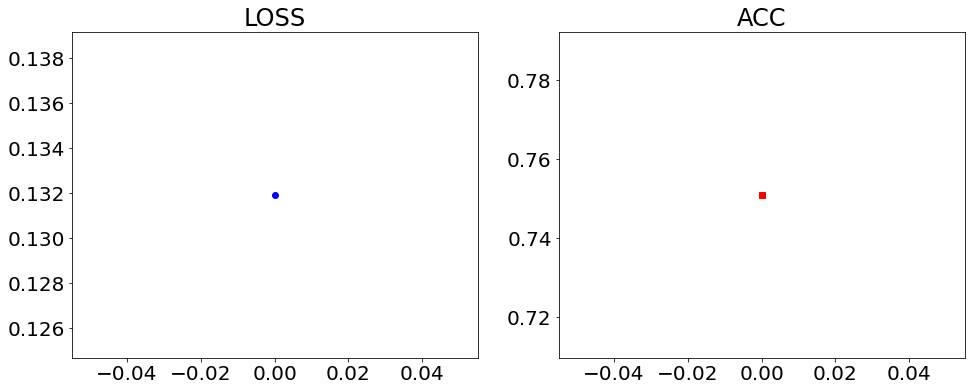

In [18]:
# 学習曲線の可視化
plt.rcParams["font.size"] = 20
fig=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(cnn1.log_loss,'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(cnn1.log_acc,'rs--');

# 問題10　出力サイズとパラメータ数の計算


1.

* 入力サイズ : 144×144, 3チャンネル
* フィルタサイズ : 3×3, 6チャンネル
* ストライド : 1
* パディング : なし

→ 出力サイズ：6×142×142

→ パラメータ数（重み）（F×C×FH×FW）：162

→ パラメータ数（バイアス）（F）：6

2.

* 入力サイズ : 60×60, 24チャンネル
* フィルタサイズ : 3×3, 48チャンネル
* ストライド　: 1
* パディング : なし

→ 出力サイズ：48×58×58

→ パラメータ数（重み）（F×C×FH×FW）：10368

→ パラメータ数（バイアス）（F）：48

3.

* 入力サイズ : 20×20, 10チャンネル
* フィルタサイズ: 3×3, 20チャンネル
* ストライド : 2
* パディング : なし

→ 出力サイズ：20x9x9

→ パラメータ数（重み）（F×C×FH×FW）：1800

→ パラメータ数（バイアス）（F）：20